### Running imports

In [1]:
from zenith import Zenith3D, Zenith2D, DrawStyles
import boto3
import sardem
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon
import gdal
from numba import jit
from orthorectification import ortho_tools, visualization_tools, scaling_tools
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

### Load an image

In [2]:
gdal.AllRegister()
ntf_dataset = gdal.Open("rio.ntf")
img = ntf_dataset.ReadAsArray()
rpcs = ortho_tools.unpack_rpc_parameters(ntf_dataset)
img.shape

(31944, 29272)

### Rescale

In [3]:
img_rescaled = scaling_tools.gaussian_rescale(img)

### Get image bounding box

In [4]:
gcps = ntf_dataset.GetGCPs()
min_lon = min([gcp.GCPX for gcp in gcps])
min_lat = min([gcp.GCPY for gcp in gcps])
max_lon = max([gcp.GCPX for gcp in gcps])
max_lat = max([gcp.GCPY for gcp in gcps])
min_lon, min_lat

(-43.20055555555556, -23.033611111111114)

In [5]:
lon_range = abs(max_lon - min_lon)
lat_range = abs(max_lat - min_lat)
lon_range, lat_range

(0.15750000000000597, 0.15166666666666728)

### Retrieve DEM tiles

In [6]:
e_matrix_raw, dem_geo_xform = ortho_tools.retrieve_dem(
    min_lon - 0.5, min_lat + 0.5, 1, 1, 2
)

[02/26 22:33:48] [INFO dem.py] Bounds: -43.70055555555556 -23.533611111111114 -42.70055555555556 -22.533611111111114
[02/26 22:33:48] [INFO dem.py] /Users/michael.pfaffenberger/.cache/sardem/S23W044.hgt already exists, skipping.
[02/26 22:33:48] [INFO dem.py] /Users/michael.pfaffenberger/.cache/sardem/S23W043.hgt already exists, skipping.
[02/26 22:33:48] [INFO dem.py] /Users/michael.pfaffenberger/.cache/sardem/S24W044.hgt already exists, skipping.
[02/26 22:33:48] [INFO dem.py] /Users/michael.pfaffenberger/.cache/sardem/S24W043.hgt already exists, skipping.
/Users/michael.pfaffenberger/anaconda3/envs/analysis/lib/python3.8/site-packages/sardem/dem.py:562: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cur_row = np.hstack(self._load_tile(tile_name) for tile_name in row)
[02/26 22:33:48] [INFO dem.py] Cropping stitched D

### Visualize the DEM

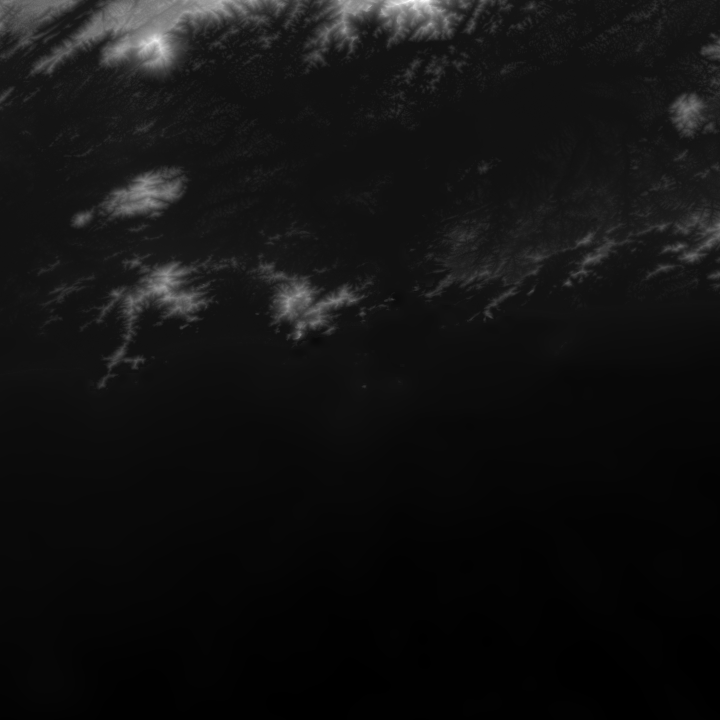

In [7]:
resize_factor = 10
e_matrix_resized = cv2.resize(
    e_matrix_raw,
    (
        int(e_matrix_raw.shape[0] / resize_factor),
        int(e_matrix_raw.shape[1] / resize_factor),
    ),
)
e_matrix = e_matrix_resized - e_matrix_raw.min()
e_matrix = e_matrix / e_matrix.max() * 255
e_matrix = e_matrix.astype(np.ubyte)
Image.fromarray(e_matrix)

### Reproject image footprint into DEM pixel space

In [8]:
footprint = [
    ortho_tools.lon_lat_to_pixel(point.GCPX, point.GCPY, dem_geo_xform)
    for point in ntf_dataset.GetGCPs()
]
footprint.append(footprint[0])
footprint = [(f[0], f[1]) for f in footprint]
polygon = Polygon(footprint)

xmin = int(min([coord[0] for coord in polygon.envelope.exterior.coords]))
xmax = int(max([coord[0] for coord in polygon.envelope.exterior.coords]))
ymin = int(min([coord[1] for coord in polygon.envelope.exterior.coords]))
ymax = int(max([coord[1] for coord in polygon.envelope.exterior.coords]))

# Crop out DEM using image_footprint
footprint_dem = e_matrix_raw[ymin:ymax, xmin:xmax]

In [15]:
x, y, elev = visualization_tools.generate_triangle_mesh(footprint_dem * 1.5, reach=10)
plot = Zenith3D()
plot.add_layer(
    x,
    y,
    elev,
    name="Elevation Mesh",
    color=(12, 59, 57, 255),
    draw_style=DrawStyles.GL_TRIANGLES,
)
plot.add_layer(
    x,
    y,
    elev,
    name="Elevation Mesh GRID",
    color=(0, 255, 90, 5),
    draw_style=DrawStyles.GL_LINES,
)
plot.show()

True

### Calculate color values in image for DEM pixel locations

In [10]:
from numba import njit

@njit
def pin_pixels_to_dem():
    xs = []
    ys = []
    zs = []
    color = []

    reach = 10
    x = np.linspace(-reach, reach, xmax - xmin)
    y = np.linspace(-reach, reach, ymax - ymin)
    for i in range(xmin, xmax - 1):
        for j in range(ymin, ymax - 1):
            lon = dem_geo_xform[0] + i * dem_geo_xform[1] + j * dem_geo_xform[2]
            lat = dem_geo_xform[3] + i * dem_geo_xform[4] + j * dem_geo_xform[5]
            altitude = e_matrix_raw[j, i]
            image_x, image_y = ortho_tools.lon_lat_alt_to_xy(lon, lat, altitude, rpcs)
            if 1 <= image_x < img.shape[1] - 1 and 1 <= image_y < img.shape[0] - 1:
                color_val = ortho_tools.linear_interp(
                    image_x, image_y, img_rescaled.reshape(-1), img.shape[1]
                )
                xs.append(x[i - xmin])
                ys.append(y[j - ymin])
                zs.append(altitude / 500)
                color.append(color_val)
                color.append(color_val)
                color.append(color_val)
    return xs, ys, zs, color

In [11]:
xs, ys, zs, color = pin_pixels_to_dem()

In [18]:
plot = Zenith3D()
plot.add_layer(
    y,
    x,
    elev,
    name="Elevation Mesh GRID",
    color=(0, 255, 90, 5),
    draw_style=DrawStyles.GL_LINES,
)
plot.add_layer(
    np.array(xs, dtype=np.float32),
    np.array(ys, dtype=np.float32),
    np.array(zs, dtype=np.float32),
    name="Elevation Pixel Intensity",
    color=(0, 0, 0, 30),
    color_data = np.array(color, dtype=np.float32) / 255.0,
    draw_style=DrawStyles.GL_POINTS
)
plot.show()

True